<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Eletronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file represents an event. All events are related to products and users. Each event has a many-to-many relationship between users and products. 

## Learning Objectives

At the end of this session, you will be able to

- Leverage `pandas_profiling` for fast data understanding
- Practice data preprocessing
- Build logistic regression / SVM / Gradient Boosting
- Evaluate models with proper metrics
- Interpret black box models with SHAP
- Generate optimal pipeline for classification task using AutoML

## Task 1: Load data

Let's start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

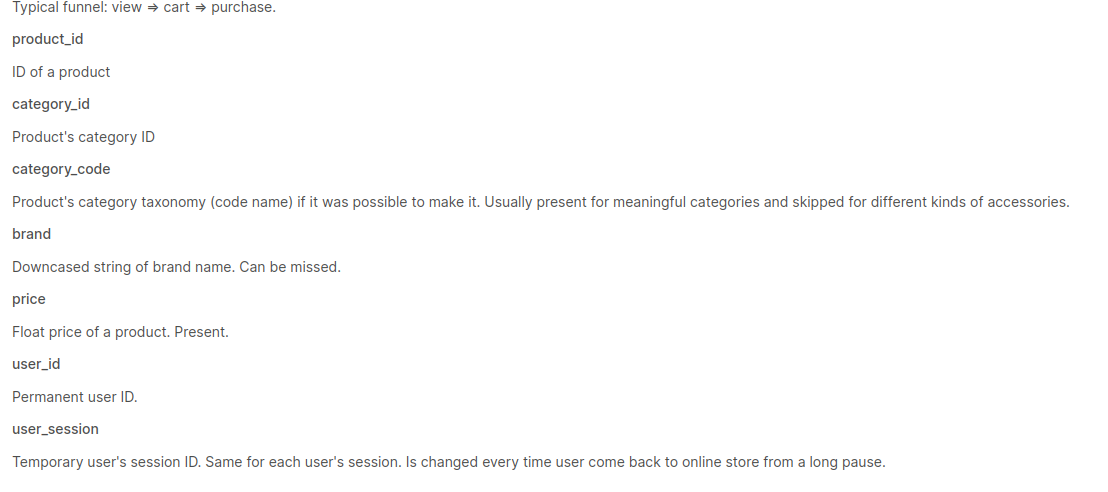

In [144]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information on user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

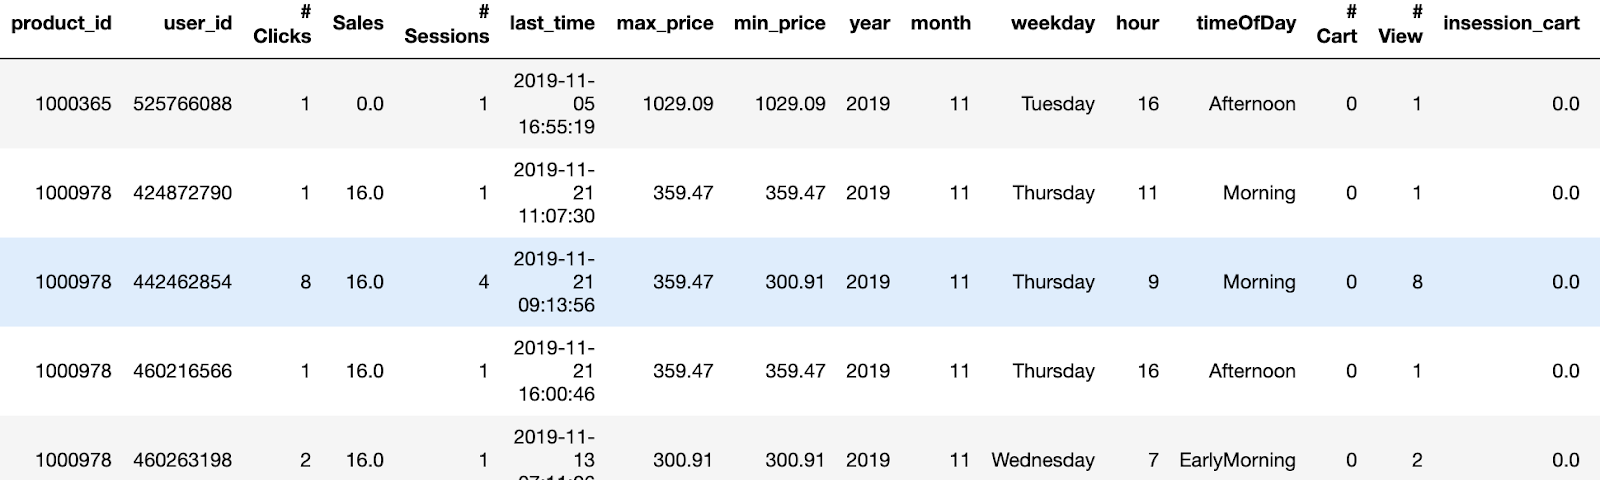

In [145]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

<font color='blue'>The user session data is available in #clickes, #sessions, #cart, #view, insession_cart. 
The product data is available in max_price, min_price. </font>

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has values either 0 (not purchased) or 1 (purchased).

In [146]:
import pandas as pd
train_df = pd.read_csv('../dat/train.csv.gz') # YOUR CODE HERE

In [147]:
# YOUR CODE HERE
train_df.head(5)

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0


4. What is the dimension of the training data?

In [148]:
# YOUR CODE HERE
print(f"Dimensions of training dataset: {train_df.shape[0]} rows and {train_df.shape[1]} columns")

Dimensions of training dataset: 645816 rows and 15 columns


5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [149]:
test_df = pd.read_csv('../dat/test.csv.gz') # YOUR CODE HERE
print(f"Dimensions of test dataset: {test_df.shape[0]} rows and {test_df.shape[1]} columns")

Dimensions of test dataset: 430544 rows and 15 columns


## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. 
To do this, we will want to identify the most important features for classification. 

Before digging into each column, let's leverage `pandas_profiling`, that goes beyond `pd.DataFrame.describe()`, to get a big picture of our data set. 

1. From `pandas_profiling` import `ProfileReport`. 
    
    For faster iteration, create a profile report object `profile` with 10,000 samples from `train_df`. 
    
    Set its `title` as "Pandas Profiling Electronics Purchase Report". 
    
    For sampling, use `pd.DataFrame.sample(10000, randome_state=3)`. 

In [150]:
# YOUR CODE HERE
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df.sample(10000, random_state=3), title="Pandas Profiling Electronics Purchase Report") # YOUR CODE HERE

   Show the report inside the notebook, go over the report and check each tab; especially the "Alerts". 

In [151]:
%%time
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 10.7 s, sys: 816 ms, total: 11.5 s
Wall time: 5.86 s


<font color='blue'>
Wall time: is how long it took for the cell to execute as if you were looking at a wall clock. 
CPU time: how many seconds the CPUs were busy with this cell. 
Typically the wall time is greater than or equal to CPU time for a single CPU, because a task may be waiting for an I/O or network operation, and not be using CPU. Here, wall time is smaller than the CPU time. This happens when we have multiple cores and we add up the time spent on each core. So a total of ~12s in CPU time, translated to 6s on wall time says that 2 cores were busy for 6s each. 
</font>

2. Pandas profiling Profile reports that there are 5 numeric variables and 11 categorical variables. Let's print out the datatype of each feature (column) and understand how the profiler infers data type. 

In [152]:
#YOUR CODE HERE
train_df.dtypes

NumOfEventsInJourney      int64
NumSessions               int64
interactionTime         float64
maxPrice                float64
minPrice                float64
NumCart                   int64
NumView                   int64
InsessionCart             int64
InsessionView             int64
year                      int64
month                     int64
weekday                  object
timeOfDay                object
Weekend                   int64
Purchase                  int64
dtype: object

<font color='blue'>Pandas profiling is treating count variables - such as `NumCart`, `NumView` etc - as categorical. The exception is when the range of count is higher; in this case, it is treated as a numeric variable; e.g. `InsessionView`.  </font>

3. From the report, we see that `year`, `month`, and `Weekend` were "Rejected" as there is only one distinct value for each column. 
These features are not informative, so we remove the three features from the training set. To do this, pass the `columns` argument to the `.drop()` method. 
Make sure to use `inplace=True` to modify the DataFrame. 
Print the shape of the DataFrames to verify the columns were dropped.

In [153]:
assert train_df.shape[1] == 15
# YOUR CODE HERE
train_df.drop(columns=['year', 'month', 'Weekend'], inplace=True)
assert train_df.shape[1] == 12

4. Repeat the steps for `test_df`:

In [154]:
# YOUR CODE HERE
test_df.drop(columns=['year', 'month', 'Weekend'], inplace=True)
assert test_df.shape[1] == train_df.shape[1]

5. As you can see from the profile report, `weekday` and `timeOfDay` each has 7 distinct values. 
Convert these non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to convert them to numeric type. 
    Follow the example given for the `weekday` column to update the `timeOfDay` column.
    Use the `.head()` method to inspect the dataset after the transformations.

In [155]:
train_df['weekday'].unique()

array(['Sat', 'Fr', 'Thu', 'Mon', 'Tue', 'Wed', 'Sun'], dtype=object)

<font color='blue'>The `unique()` function is not useful, because we want to preserve the temporal order in the classes. So we of explicitly provide the categorical values, the days of the week, to be enumerated. </font>

In [156]:
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
weekday_str2num

{'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fr': 5, 'Sat': 6, 'Sun': 7}

In [157]:
train_df['weekday'] = train_df['weekday'].replace(weekday_str2num)
train_df['weekday'].unique()

array([6, 5, 4, 1, 2, 3, 7])

In [158]:
train_df['timeOfDay'].unique()

array(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'], dtype=object)

In [159]:
timeOfDay_str2num =  {
    s: i+1 for i, s in enumerate(['Dawn', 'EarlyMorning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night'])
} # YOUR CODE HERE
train_df['timeOfDay'] = train_df['timeOfDay'].replace(timeOfDay_str2num) # YOUR CODE HERE
train_df['timeOfDay'].unique()

array([3, 1, 5, 4, 6, 2, 7])

6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric type. 

In [160]:
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num) # YOUR CODE HERE
test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num) # YOUR CODE HERE

7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Compare it to what the profile reports. Is the dataset balanced?

In [161]:
print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts())
print(f"percent of rows resulting in purchase: {100 * train_df['Purchase'].sum()/len(train_df['Purchase'])}% same as {100*8977/(8977 + 636839)}%") # YOUR CODE HERE

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64
percent of rows resulting in purchase: 1.3900244032355966% same as 1.3900244032355966%


<font color='blue'>The data is clearly not balanced as the proportion of user/product pairs that result in a purchase `Purchase=1` is only 1.39%. </font>

## Task 3: Preprocess Data

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forest can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

<font color='blue'>We started with 11 numeric and 4 categorical variables. The target variable `Purchase` was one of the numeric variables. So total features at first = 14. We removed 3. So we should have 11 features.</font>

In [162]:
# YOUR CODE HERE
len(train_df.columns)-1

11

2. Drop the features with high correlation.

    In the "Correlations" tab in the profile report, you can find heatmap using five different correlation metrics; toggle correlation desciptions if any one of them looks foreign to you.  

    We'll remove high correlated features by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given most of the code, make sure that you understand what each line does.
    
    First, calculate the correlation with just 10,000 samples.

In [163]:
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 
cor = train_small_df.corr() # YOUR CODE HERE

In [164]:
cor

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,weekday,timeOfDay,Purchase
NumOfEventsInJourney,1.000000,0.820386,0.502779,0.019786,0.018034,0.169965,0.562265,0.142453,0.099629,0.023316,-0.022551,0.107172
NumSessions,0.820386,1.000000,0.628841,0.020670,0.018456,0.145634,0.462171,0.108800,0.028005,0.014853,-0.031422,0.074800
interactionTime,0.502779,0.628841,1.000000,0.013432,0.010612,0.054007,0.316047,0.039385,0.016925,0.000565,-0.010380,0.025312
maxPrice,0.019786,0.020670,0.013432,1.000000,0.999976,-0.009437,0.017823,-0.012768,-0.022749,0.003485,-0.001615,0.006733
minPrice,0.018034,0.018456,0.010612,0.999976,1.000000,-0.009691,0.016752,-0.012980,-0.022768,0.003412,-0.001555,0.006693
NumCart,0.169965,0.145634,0.054007,-0.009437,-0.009691,1.000000,-0.596957,0.919035,-0.272776,0.029040,-0.014195,-0.002761
NumView,0.562265,0.462171,0.316047,0.017823,0.016752,-0.596957,1.000000,-0.562690,0.345214,-0.011738,0.008444,-0.355151
InsessionCart,0.142453,0.108800,0.039385,-0.012768,-0.012980,0.919035,-0.562690,1.000000,-0.240111,0.035035,-0.013866,0.006669
InsessionView,0.099629,0.028005,0.016925,-0.022749,-0.022768,-0.272776,0.345214,-0.240111,1.000000,0.040195,0.068041,-0.171515
weekday,0.023316,0.014853,0.000565,0.003485,0.003412,0.029040,-0.011738,0.035035,0.040195,1.000000,-0.034884,0.018331


In [165]:
train_small_df.columns

Index(['NumOfEventsInJourney', 'NumSessions', 'interactionTime', 'maxPrice',
       'minPrice', 'NumCart', 'NumView', 'InsessionCart', 'InsessionView',
       'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

<font color='blue'>cor(`NumOfEventsInJourney`, `NumSessions`)=0.82. We expect one of these columns to be removed with a threshold of 0.8. </font>

In [166]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [167]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


<font color='blue'>Indeed, `NumEvents` was removed. </font>

3. How many columns are left in the DataFrame?

In [168]:
# YOUR CODE HERE
print(f"We are left with {len(train_df_reduced.columns)} columns")

We are left with 9 columns


4. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [169]:
test_df_reduced = test_df[selected_columns] # YOUR CODE HERE
assert test_df_reduced.shape[1] == 9

5. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

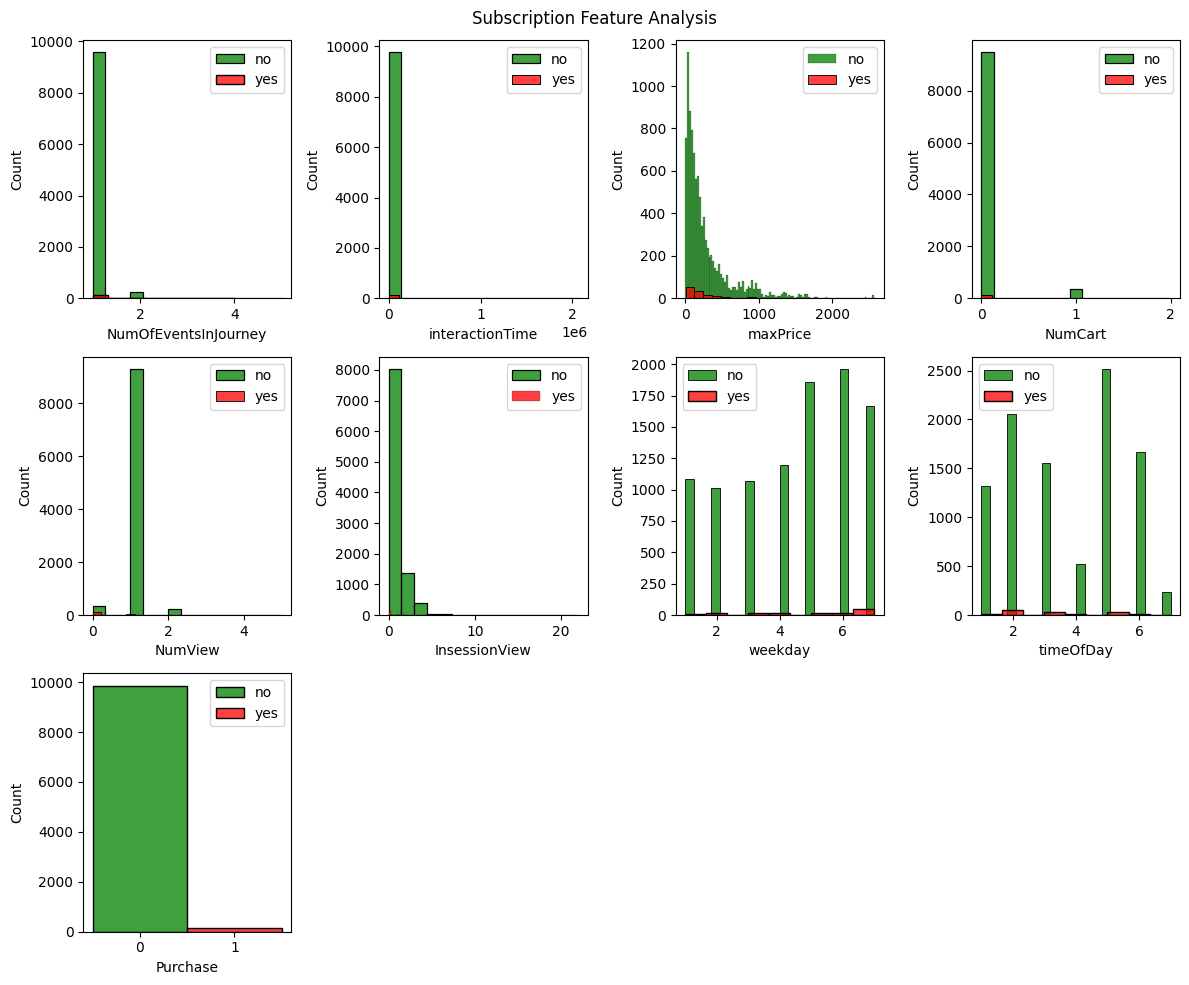

In [234]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

<font color='blue'>The number of `Purchase=1` is only 1.39% of the entire dataset. Because of this imbalance, the above visualisations do not provide any insights into which features in the user-journey data contribute to a purchase. Irrespective of whether a purchase is made or not, it appears that:
* we have more entries for certain `weekday` and `timeOfDay` for example. 
* Also, more entries are available for lower values of `maxPrice` - right skewed distribution. </font>

6. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [171]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values # YOUR CODE HERE
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values # YOUR CODE HERE

7. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [172]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # YOUR CODE HERE
scaler.fit(X_train_reduced)
X_train_reduced = scaler.transform(X_train_reduced) # YOUR CODE HERE
scaler.fit(X_test_reduced)
X_test_reduced = scaler.transform(X_test_reduced) # YOUR CODE HERE

In [173]:
#Check scaling
print(f" X_train_reduced: min= {X_train_reduced.min()}, max= {X_train_reduced.max()}")
print(f" X_test_reduced: min= {X_test_reduced.min()}, max= {X_test_reduced.max()}")

 X_train_reduced: min= 0.0, max= 1.0
 X_test_reduced: min= 0.0, max= 1.0


## Task 4: Build Logistic Regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [174]:
# Import the models from sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict using the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter (what happens if we don't?).

    Remember to use the ***train*** data for training the model and the ***test*** data when making predictions.

In [235]:
%%time
lr_model = LogisticRegression(random_state=42, class_weight="None") # YOUR CODE HERE
lr_model.fit(X_train_reduced, y_train)
lr_pred = lr_model.predict(X_test_reduced) # YOUR CODE HERE

CPU times: user 8.36 s, sys: 305 ms, total: 8.67 s
Wall time: 1.29 s


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [180]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9986366085696236
precision: 0.986802745029034
recall: 0.9163398692810457
f1 score: 0.950266881301364
confusion matrix:
[[424349     75]
 [   512   5608]]


In [260]:
%%time
lr_model = LogisticRegression(class_weight="balanced", random_state=0).fit(X_train_reduced, y_train) # YOUR CODE HERE
#lr_model.fit(X_train_reduced, y_train)
lr_pred = lr_model.predict(X_test_reduced) # YOUR CODE HERE

CPU times: user 7.83 s, sys: 160 ms, total: 7.99 s
Wall time: 1.18 s


In [262]:
pd.DataFrame(X_train_reduced)

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.059987,0.0,0.111111,0.014706,0.833333,0.333333
1,0.0,0.0,0.036001,0.0,0.111111,0.014706,0.666667,0.000000
2,0.0,0.0,0.060492,0.0,0.111111,0.014706,0.500000,0.666667
3,0.0,0.0,0.348988,0.0,0.111111,0.014706,0.000000,0.500000
4,0.0,0.0,0.056801,0.0,0.111111,0.014706,0.166667,0.500000
...,...,...,...,...,...,...,...,...
645811,0.0,0.0,0.049987,0.0,0.111111,0.029412,0.833333,0.166667
645812,0.0,0.0,0.094990,0.0,0.111111,0.014706,0.500000,0.166667
645813,0.0,0.0,0.059369,0.0,0.111111,0.014706,1.000000,0.166667
645814,0.0,0.0,0.073899,0.0,0.111111,0.014706,0.333333,0.833333


In [263]:
pd.DataFrame(X_test_reduced)

,0,1,2,3,4,5,6,7
0,0.0000,0.000000,0.049284,0.0,0.090909,0.014706,0.333333,0.166667
1,0.0625,0.000073,0.045989,0.0,0.181818,0.014706,0.666667,0.166667
2,0.0000,0.000000,0.024774,0.0,0.090909,0.014706,0.666667,0.333333
3,0.0000,0.000000,0.012502,0.0,0.090909,0.044118,0.666667,0.166667
4,0.0000,0.000000,0.424899,0.0,0.090909,0.029412,0.833333,0.166667
...,...,...,...,...,...,...,...,...
430539,0.0000,0.000000,0.009899,0.0,0.090909,0.014706,0.333333,0.833333
430540,0.0000,0.000000,0.006398,0.0,0.090909,0.014706,0.833333,0.333333
430541,0.0000,0.000000,0.015000,0.0,0.090909,0.029412,0.500000,0.833333
430542,0.1250,0.057653,0.188989,0.0,0.272727,0.029412,1.000000,0.000000


In [261]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9603129993682411
precision: 0.26363205310573734
recall: 0.9993464052287582
f1 score: 0.41720386097752304
confusion matrix:
[[407341  17083]
 [     4   6116]]


<font color='blue'>It appears that using class_weight='balance' is resulting in worse precision, drops to 0.26 from 0.99. This is because of an increase in false positives. Since class=0 is the majority class with the loss for misclassification of class=0 is penalised much lower than the minority class. The model therefore makes more mistakes with the majority class, resulting in many more false positives. But note that the recall goes up from 0.92 to 0.999 - so the model has learnt to classify class=1 much better thanks to class weighting. <font>

<font color='blue'> The class weights can be explicitly provided as well. With class_weight={0:1, 1:1}, we have the same scenario as class_weight='None'. If the recall values are acceptable, then in this example, this setting for class_weight is good, even though we are working with imbalanced classes. </font>

In [252]:
%%time
lr_model = LogisticRegression(random_state=42, class_weight={0:0.3, 1:1}) # YOUR CODE HERE
lr_model.fit(X_train_reduced, y_train)
lr_pred = lr_model.predict(X_test_reduced) # YOUR CODE HERE

CPU times: user 8.35 s, sys: 200 ms, total: 8.55 s
Wall time: 1.29 s


In [253]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9979676873908357
precision: 0.9329701172197458
recall: 0.9233660130718955
f1 score: 0.9281432208261476
confusion matrix:
[[424018    406]
 [   469   5651]]


3. Instantiate, train and predict using the SVM model. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account for the class imbalance.

In [183]:
%%time
svm_model = LinearSVC(random_state=42) # YOUR CODE HERE 
svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)

CPU times: user 3.63 s, sys: 48.6 ms, total: 3.68 s
Wall time: 3.68 s


4. ❓ What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).


<font color='blue'>For n data points with d variables (dimensions):
* Train time complexity of SVM is O(n*n) 
* Train time complexity of Logistic Regression is O(n*d)

In our case n~600K and d=11. And this is typical of most datasets that n>>d. So SVM has a higher time complexity than logistic regression. However interestingly in this example, SVM cpu time is only 3.68 whereas the logistic regression adds up to 8.54s. </font>

5. Calculate the classification metrics for the SVM model. 

Here you can use a helper function to display all the metrics. 

Inspect the source code to understand how to use the function. 

In [184]:
from utils import display_metrics
# YOUR CODE HERE
display_metrics(y_test, svm_pred)

Confusion Matrix: 
[[424049    375]
 [     1   6119]]
Accuracy: 0.999
Recall: 1.000
Precision: 0.942
F1 Score: 0.970


Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

In [195]:
pd.DataFrame(list(zip(train_df_reduced.drop(columns='Purchase').columns, lr_model.coef_[0], svm_model.coef_[0])), columns=['Variables', 'LogisticRegression', 'SVM'])

,Variables,LogisticRegression,SVM
0,NumOfEventsInJourney,95.386828,21.120724
1,interactionTime,5.567001,0.104435
2,maxPrice,0.142126,0.000121
3,NumCart,-72.725284,-17.755062
4,NumView,-89.523675,-17.634382
5,InsessionView,-15.367669,-1.243739
6,weekday,0.098160,0.000080
7,timeOfDay,-0.226949,-0.000130


<font color='blue'>Both models agree on the direction of impact of the features to the final prediction as well as the order of the feature importance (ranking based on coefficients), however the coefficient values vary. 
* `NumCart`, `NumView`, `InSessionView` and `timeOfDay` have a negative impact on the final prediction, whereas the rest have a positive impact. 
* `NumOfEventsInJourney` tops the features in terms of importance for both models. </font>

## Task 5: Explanability with SHAP

Intepretation of a linear model such as logistic regression is staightforward, however, some tree-based models have a different reputation. In this task, we will fit a non-linear classifier: begin with gradient boosted tree, and use SHAP to help intepret the model. 

1. What are training coefficients from logistic regression? ( how about SVM? check [How does one interpret SVM feature weights?](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights) )

    Leave your comments on interpretation of this logistic regression model.

In [196]:
# YOUR CODE HERE
for i in range(len(train_df_reduced.columns)-1): 
    print(f"{train_df_reduced.columns[i]}: {lr_model.coef_[0][i]}")
# lr_model.coef_

NumOfEventsInJourney: 95.38682777442385
interactionTime: 5.567000811479989
maxPrice: 0.14212635491779968
NumCart: -72.72528365993377
NumView: -89.5236748929995
InsessionView: -15.367668580499071
weekday: 0.09815997673587196
timeOfDay: -0.22694871939724456


<font color='blue'> Interpretation of logistic regression coefficients - see previous section. </font>

2. Instantiate, train, and predict using the Gradient Boosted Trees model.

In [197]:
from sklearn.ensemble import GradientBoostingClassifier

In [198]:
%%time
gbt_model = GradientBoostingClassifier() # YOUR CODE HERE
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)

CPU times: user 26 s, sys: 783 ms, total: 26.7 s
Wall time: 26.8 s


<font color='blue'>Train time complexity of gradient boosting classifier = O(n * log(n) * d * m)
Where m=no. of decision trees considered. So this is more complex than logistic regression and SVM. Our wall time agrees with this formula. </font>

3. Evaluate the model by calculating the classification metrics.

In [199]:
# YOUR CODE HERE
display_metrics(y_test, gbt_pred)

Confusion Matrix: 
[[424136    288]
 [   108   6012]]
Accuracy: 0.999
Recall: 0.982
Precision: 0.954
F1 Score: 0.968


4. SHAP (SHapley Additive exPlanations) is a game theory approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

    For this task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. 

5. Consider experimenting on a smaller dataset. 

For example, start with a subset of 100 samples from the test data.

Once the script works properly, use all the data from `X_test_reduced`. 

Apply `shap.Explainer()` to calculate the SHAP values for the Gradient Boosting classifier you fit earlier.

In [200]:
np.random.seed(123)
subset_size = X_test_reduced.shape[0] # start with 100
idx = np.random.randint(X_test_reduced.shape[0], size=subset_size)
X_test_reduced_subset = X_test_reduced[idx, ]

assert X_test_reduced_subset.shape == (subset_size, 8)

In [202]:
import shap
explainer = shap.TreeExplainer(gbt_model)# YOUR CODE HERE

In [203]:
%%time
shap_values = explainer.shap_values(X_test_reduced_subset) # YOUR CODE HERE

CPU times: user 14.9 s, sys: 136 ms, total: 15 s
Wall time: 15 s


6. visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


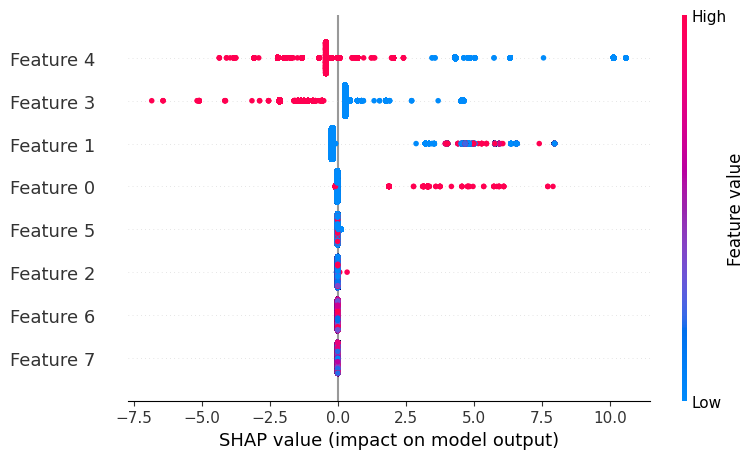

In [210]:
# YOUR CODE HERE
shap.summary_plot(shap_values, X_test_reduced_subset)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


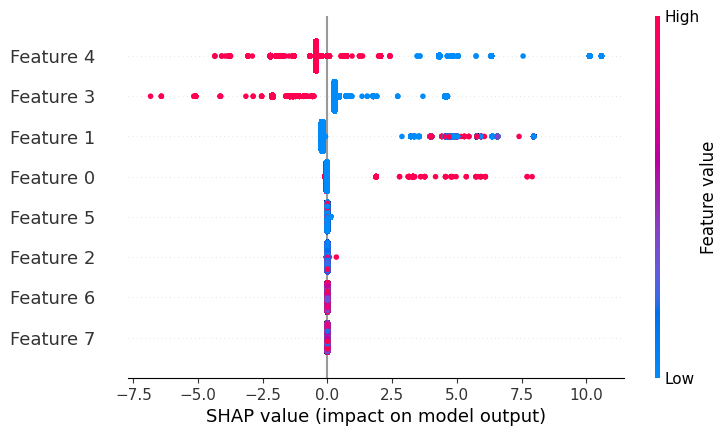

In [216]:
shap_values = explainer(X_test_reduced_subset)
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0))

<font color='blue'>In the plot above, higher values for feature 4 (red dots), leads to negative SHAP values (negative impact on model output). Same goes for feature 3. 

But for feature 1 and 0, higher values of features have positive values of SHAP (positive impact on model output). </font>

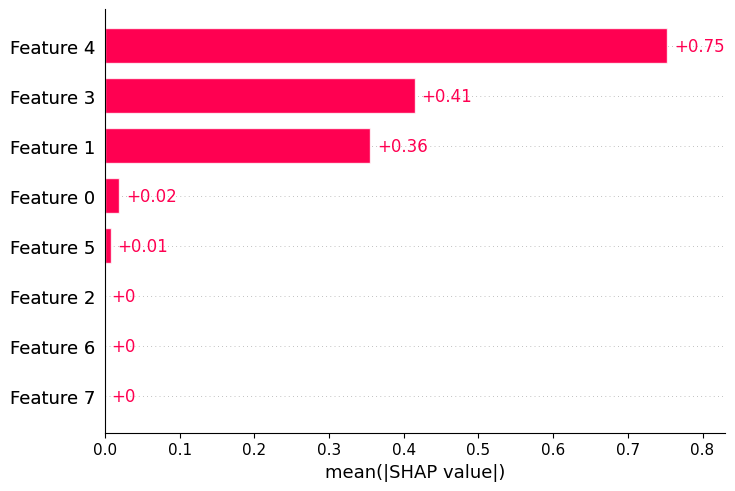

In [215]:
shap.plots.bar(shap_values.abs.mean(0))

7. What are features 4, 3, and 1? Does each feature positively or negatively contribute to the likelihood of purchase?

In [226]:
# YOUR CODE HERE
pd.DataFrame(list(zip(train_df_reduced.columns, lr_model.coef_[0], svm_model.coef_[0])), columns=['Variables', 'LogisticRegression', 'SVM'])

,Variables,LogisticRegression,SVM
0,NumOfEventsInJourney,95.386828,21.120724
1,interactionTime,5.567001,0.104435
2,maxPrice,0.142126,0.000121
3,NumCart,-72.725284,-17.755062
4,NumView,-89.523675,-17.634382
5,InsessionView,-15.367669,-1.243739
6,weekday,0.098160,0.000080
7,timeOfDay,-0.226949,-0.000130


<font color='blue'> Feature 4: `NumView`, Feature 3: `NumCart` - negative impact according to the distribution of SHAP values, and have negative coefficients in the logistic regression and SVM.

Feature 1: `interactionTime` has positive impact according to SHAP values distribution, and agrees with logistic regression, and SVM coefficients' signs. </font>

8. Visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


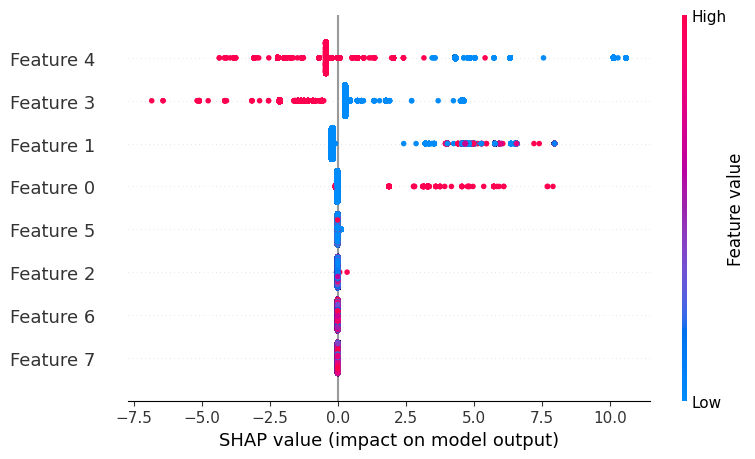

In [227]:
# YOUR CODE HERE
shap_values = explainer.shap_values(X_test_reduced)
shap.summary_plot(shap_values, X_test_reduced)


In [232]:
shap.initjs()
idx = 20
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_reduced[idx],
)

9. Write your data (shap values) to a file and add them under the Model Explainability tab in the Streamlit app (see next section), following the example in Model Results tab.

10. Optional. Do the same for a random forest model.

## Task 6: AutoML

Let's see how AutoML performs on this imbalanced dataset. Similarly, for faster iteration on our workflow, experiment it on a small smaple. 

1. Take 5,000 samples from `train_df`, 5,000 from `test_df` for experimenting.

In [ ]:
train_features = train_df.sample(int(5e3), random_state=42)
train_label = train_features.pop('Purchase')
test_features = test_df.sample(int(5e3), random_state=42)
test_label = test_features.pop('Purchase')

2. Instantiate and train a TPOT auto-ML classifier.

    The parameters in the code below are set to low values for faster iterations. 
    Read about each parameters [here](http://epistasislab.github.io/tpot/api/#classification) and experiment with different values when time permits.
    
    Set a proper [`scoring` function](http://epistasislab.github.io/tpot/using/#scoring-functions). 

In [ ]:
%%time
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=10, 
                      population_size=16,
                      scoring="f1_weighted",# YOUR CODE HERE
                      verbosity=2,
                      random_state=42)
tpot.fit(train_features, train_label)
print(f"Tpop score on test data: {tpot.score(test_features, test_label):.2f}")
tpot.export('tpot_electronics_pipeline.py')

3. Examine the model pipeline that TPOT classifier offers in the python file `tpot_electronics_pipeline.py` in the `nb` directory. 
If you see any model, function, or class that are not familiar, look them up!

    Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate.

In [ ]:
!cat tpot_electronics_pipeline.py # A sample output

4. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_electronics_pipeline.py` to build a model on our training set and make predictions on the test set. 

    Choose approriate metrics to evaluate the prediction from TPOT. 
    
    Optional. Add this to Streamlit `models` in the next section.

## Advanced Visualizations with Streamlit and Plotly!
Let's visualize our results in a way that makes it easy to compare our models!  
[Streamlit](https://streamlit.io/) is a Python package that makes it easy to create bespoke, dynamic and interactive web apps for visualizations.  
Lightweight web apps like this are a great way to present results to stakeholders! 

First we need to build our results dataset to render in Streamlit.

In [ ]:
from collections import defaultdict

results_data = defaultdict(list)

models = ["Logistic Regression", "SVM", "Gradient Boosting Classifier"]

for model, pred in zip(models, [lr_pred, svm_pred, gbt_pred]):
    confusion = confusion_matrix(y_test, pred)
    accuracy_ = accuracy(y_test, pred)
    recall_ = recall(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    results_data['model'].append(model)
    results_data['tn'].append(confusion[0][0])
    results_data['fp'].append(confusion[0][1])
    results_data['fn'].append(confusion[1][0])
    results_data['tp'].append(confusion[1][1])
    results_data['accuracy'].append(accuracy_)
    results_data['recall'].append(recall_)
    results_data['f1_score'].append(f1)
results_df = pd.DataFrame(results_data)
results_df

In [ ]:
# Write our results_df to CSV
results_df.to_csv("../dat/model_results.csv")

2. Then, we need to build Stremlit app. 
For today's assignment, we wrote the code for you.
However, understand the code in `electronics_purchase_predictions_streamlit.py` because you might need to write a Streamlit web app on your own for the future assignments. 

3. Once you inspected the code, you will need to start streamlit from CLI. 
Try looking up how to do this yourself.

HINT: this is a python file - maybe if you run it as a python file from the CLI, it will give you further instructions. 

Note - once you run the stremlit, the prompt will ask you to provide an email. 
You can leave the email blank. 

And you are done! 

## References

- This work is motivated by this [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)
- [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
- [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

## Answers to Rubrics Questions

### Algorithm Understanding
* Is SVM (Support Vector Machine) a supervised or unsupervised learning algorithm?

<font color='blue'>SVM is a supervised learning algorithm that can be used for regression, classification and outlier detection. </font> 

* Why is SVM such a powerful classification method?

<font color='blue'>SVM is a powerful classification method because it uses the points closest to the maximum margin between classes to classify, therefore the outliers have less effect on the classification. Second, it works well in high dimension spaces. If the number of samples is smaller than the number of dimensions, SVM can still be used. The decision boundary can be non-linear with the use of kernel functions. Finally it only uses a subset of training points in the decision function, i.e. the support vectors and therefore is memory efficient. </font> 

* What are 3 disadvantages of SVMs?

<font color='blue'> (1) SVMs do not provide probability estimates for the classification. (2) Results depend on the careful choice of the tuning parameter C that allows soft margins - if the target classes are overlapping without a clear margin, SVM may not perform well if C is chosen poorly. (3) SVMs dont work well with large datasets because the training time is O(n*n) </font> 

### Interview Readiness
* What is the time complexity of SVM?
* What is it for Logistic Regression?

<font color='blue'> For n data points with d variables (dimensions):
* Train time complexity of SVM is O(n*n) 
* Train time complexity of Logistic Regression is O(n*d) </font>

* Explain feature importance for the Random Forest algorithm?
* When examining feature importance, what is Gini impurity or information gain?

<font color='blue'>The Random forest algorithm is essentially a collection of decision trees. It is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Each decision tree has nodes represented by features. When the decision tree is trained, the feature to be used at a particular node is chosen based on how well the feature splits the dataset into the target classes. The criterion used to evaluate the quality of split can be: 
* Gini impurity - the feature that provides the largest decrease in impurity is selected. So the root node of the tree is the feature with the lowest gini impurity value.  
* Information gain - this measures the reduction in entropy (surprise) by splitting the dataset 

We can also use these criteria to measure feature importance. 
 </font>

In [254]:
from sklearn.ensemble import RandomForestClassifier

In [255]:
rf_model = RandomForestClassifier(n_estimators=3, max_depth=3, random_state=42)
rf_model.fit(X_train_reduced, y_train)
rf_pred = rf_model.predict(X_test_reduced)

In [256]:
tree_list = rf_model.estimators_

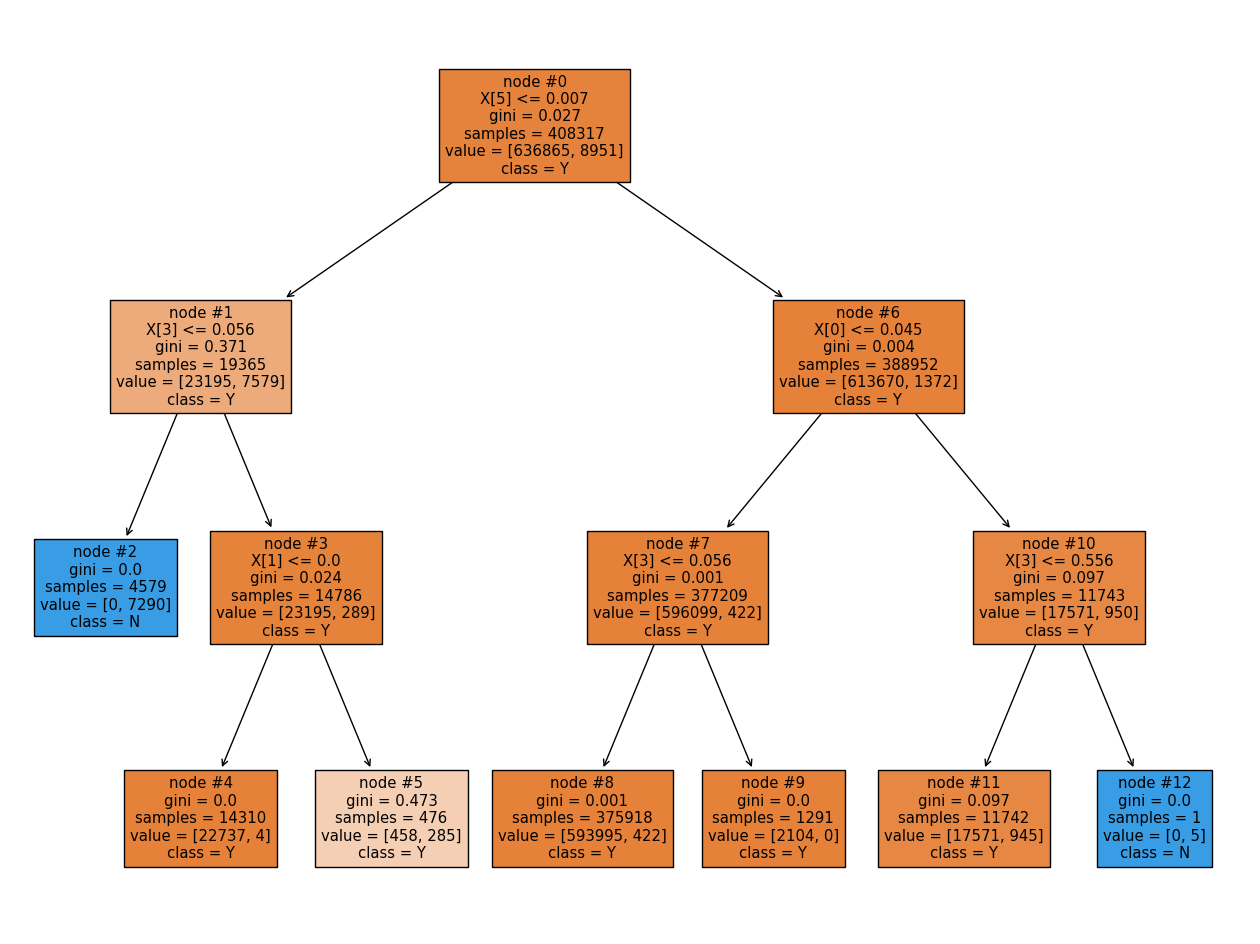

In [257]:
from sklearn import tree

plt.figure(figsize=(16, 12))
tree.plot_tree(
    tree_list[0],
    filled=True,
    class_names=["Y", "N"],
    node_ids=True,
);

<font color='blue'> I am not able to show the feature importance using gini impurity or information gain for the random forest. Conceptually the most important features are the ones at the highest levels of the tree (closest to the root)</font>

* SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model, what is it and how does it work?

<font color='blue'> </font>

<font color='blue'> SHAP is a method to explain individual predictions. 
* To explain the prediction, SHAP computes the contribution of each feature to the prediction. 
* Feature values of a data instance are the <b> players in a coalition</b>. In tabular data, the player is a single feature value as in the example in this assignment. For images, a player is a group of values - e.g. it is a collection of pixel values into a superpixel. 
* Shapley values are computed for each data instance & feature pair, and we get a matrix of mxn where there are m data instances and n features. The entire model can be interepreted by analysing this matrix.
* Feature importance can be calculated by computing the average absolute Shapley values for that feature across the data. The larger this, higher the importance of the feature. 
* The summary plot shows the impact of the features by plotting all the shapley values in the mxn matrix such that: x-axis is the shapley value, Y-axis is the feature and the color of the dots is the feature value. </font>